https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

In [12]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix

In [13]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras import layers,models,Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.13.0


Open File

In [15]:
path = r'D:\Study\Project For work\animal classification\animals'

data = {"imgpath": [], "label": []}
categories = os.listdir(path)

for category in categories:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        for image in images:
            image_path = os.path.join(category_path, image)
            data["imgpath"].append(image_path)
            data["label"].append(category)

df = pd.DataFrame(data) 
lb = LabelEncoder()
df['encoded_label'] = lb.fit_transform(df['label'])


In [16]:
df

imgpath     label  \
0     D:\Study\Project For work\animal classificatio...  antelope   
1     D:\Study\Project For work\animal classificatio...  antelope   
2     D:\Study\Project For work\animal classificatio...  antelope   
3     D:\Study\Project For work\animal classificatio...  antelope   
4     D:\Study\Project For work\animal classificatio...  antelope   
...                                                 ...       ...   
5395  D:\Study\Project For work\animal classificatio...     zebra   
5396  D:\Study\Project For work\animal classificatio...     zebra   
5397  D:\Study\Project For work\animal classificatio...     zebra   
5398  D:\Study\Project For work\animal classificatio...     zebra   
5399  D:\Study\Project For work\animal classificatio...     zebra   

      encoded_label  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
5395             89  
5396             89  
5397             89  
5398             89  
5399             89  

[5400 rows x 3 columns]

Plot Sample data

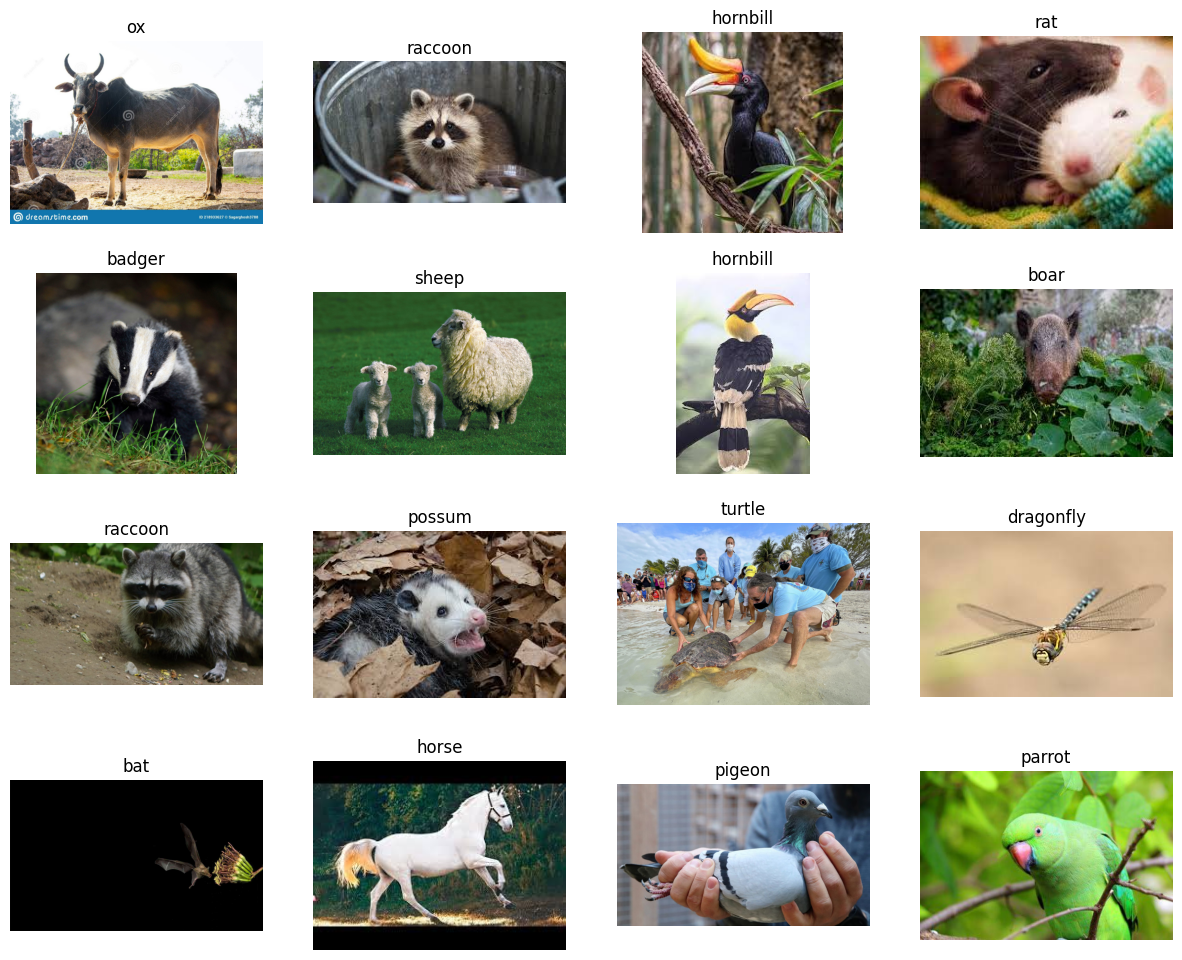

In [ ]:
#Plot Picture
plt.figure(figsize=(15,12))
for i, row in df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["label"])
    plt.axis('off')
plt.show()

Split Data to train test and validation data

In [18]:
train_df, Temp_df = train_test_split(df,  train_size= 0.7 , shuffle=True, random_state=122)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.5 , shuffle=True, random_state=122)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df["label"].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df["label"].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[ "label"].head(5))
print(test_df.shape)

----------Train-------------
0           gorilla
1          kangaroo
2    pelecaniformes
3          hedgehog
4         porcupine
Name: label, dtype: object
(3779, 3)
--------Validation----------
0        panda
1    dragonfly
2          dog
3     starfish
4        squid
Name: label, dtype: object
(810, 3)
----------Test--------------
0    parrot
1     mouse
2    pigeon
3    parrot
4       fly
Name: label, dtype: object
(811, 3)


Image generator

In [ ]:
#Image generator
batch_size = 15
img_size = (224,224)

generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
train_image_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

train_images = train_image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,   
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 810 validated image filenames belonging to 90 classes.
Found 811 validated image filenames belonging to 90 classes.


In [20]:
num_classes = len(df['label'].unique())
print(num_classes)

90


Create model

In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(224,224,3), name='input'))

#Use EfficientNetB3 Pretrain Model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224,224,3),
    include_top=False, 
    weights='imagenet',
    pooling='max')

for layer in pretrained_model.layers:
    layer.trainable = False

model.add(pretrained_model)
model.add(Dense(256 ,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes ,activation = 'softmax' ,dtype = tf.float32))


model.compile(optimizer=Adam(0.0005),loss='categorical_crossentropy',metrics=['accuracy'] )

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 90)                23130     
                                                                 
Total params: 11201161 (42.73 MB)
Trainable params: 41

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(train_images, epochs=15, steps_per_epoch=len(train_images) , validation_data=val_images, validation_steps=len(val_images),
                    callbacks = [early_stopping])


Epoch 1/15
252/252 [==============================] - 248s 951ms/step - loss: 2.4596 - accuracy: 0.4813 - val_loss: 0.7346 - val_accuracy: 0.8457
Epoch 2/15
252/252 [==============================] - 237s 940ms/step - loss: 0.9865 - accuracy: 0.7743 - val_loss: 0.4649 - val_accuracy: 0.8827
Epoch 3/15
252/252 [==============================] - 232s 920ms/step - loss: 0.6628 - accuracy: 0.8365 - val_loss: 0.3384 - val_accuracy: 0.9111
Epoch 4/15
252/252 [==============================] - 238s 943ms/step - loss: 0.5167 - accuracy: 0.8706 - val_loss: 0.3256 - val_accuracy: 0.9173
Epoch 5/15
252/252 [==============================] - 233s 923ms/step - loss: 0.4571 - accuracy: 0.8841 - val_loss: 0.3078 - val_accuracy: 0.9086
Epoch 6/15
252/252 [==============================] - 237s 941ms/step - loss: 0.3835 - accuracy: 0.9082 - val_loss: 0.2925 - val_accuracy: 0.9222
Epoch 7/15
252/252 [==============================] - 238s 944ms/step - loss: 0.3459 - accuracy: 0.9108 - val_loss: 0.2415 -

In [23]:
model.save("animal.h5")

Model Evaluate

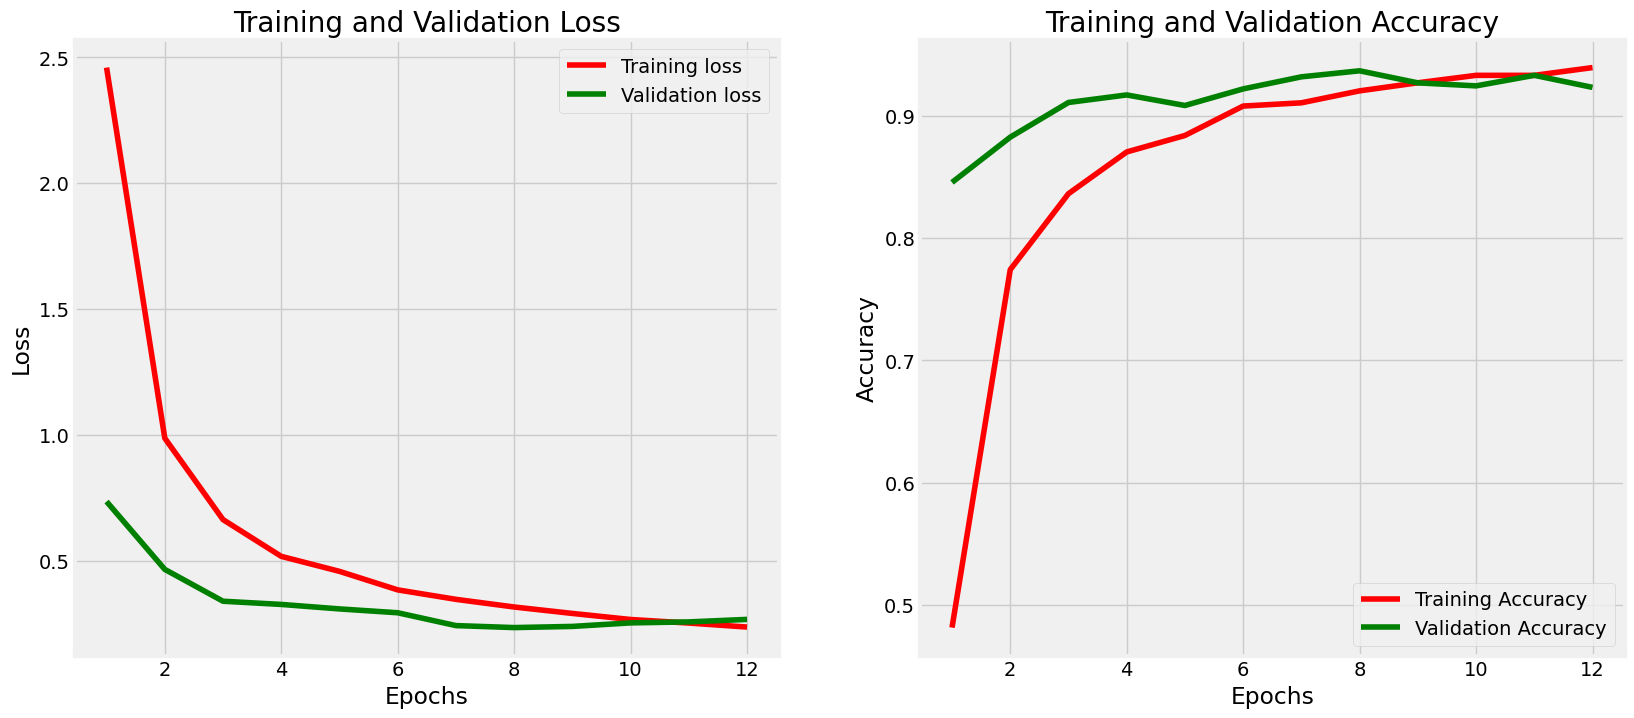

In [ ]:
#model Evaluate
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

#Accuracy
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.32052
Test Accuracy: 91.00%


In [26]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

55/55 [==============================] - 45s 780ms/step
F1 Score: 0.9043164988524541
                precision    recall  f1-score   support

      antelope       0.62      0.71      0.67         7
        badger       0.83      1.00      0.91         5
           bat       0.88      0.78      0.82         9
          bear       1.00      1.00      1.00        12
           bee       1.00      1.00      1.00         4
        beetle       0.92      1.00      0.96        12
         bison       0.86      1.00      0.92         6
          boar       0.88      1.00      0.93         7
     butterfly       0.71      1.00      0.83        10
           cat       1.00      0.83      0.91         6
   caterpillar       1.00      0.62      0.76        13
    chimpanzee       1.00      0.92      0.96        12
     cockroach       1.00      1.00      1.00        13
           cow       1.00      0.50      0.67        10
        coyote       1.00      0.83      0.91        12
          crab    

Test Prediction 

In [29]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))],
                            "Path": test_images.filenames,
                           })
Predictions.head(8)

55/55 [==============================] - 43s 774ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           60       parrot                 60   
1            1           51        mouse                 22   
2            2           64       pigeon                 64   
3            3           60       parrot                 78   
4            4           26          fly                 26   
5            5           35     hedgehog                 33   
6            6           82        tiger                 82   
7            7           33      hamster                 33   

  Prediction Classes  Prediction Probability  \
0             parrot                0.998001   
1               duck                0.084504   
2             pigeon                0.994470   
3              squid                0.504719   
4                fly                0.974402   
5            hamster                0.868250   
6              tiger                0.999906   
7            hamster                0.768163   

                                                Path  
0  D:\Study\Project For work\animal classificatio...  
1  D:\Study\Project For work\animal classificatio...  
2  D:\Study\Project For work\animal classificatio...  
3  D:\Study\Project For work\animal classificatio...  
4  D:\Study\Project For work\animal classificatio...  
5  D:\Study\Project For work\animal classificatio...  
6  D:\Study\Project For work\animal classificatio...  
7  D:\Study\Project For work\animal classificatio...

Show random test data 

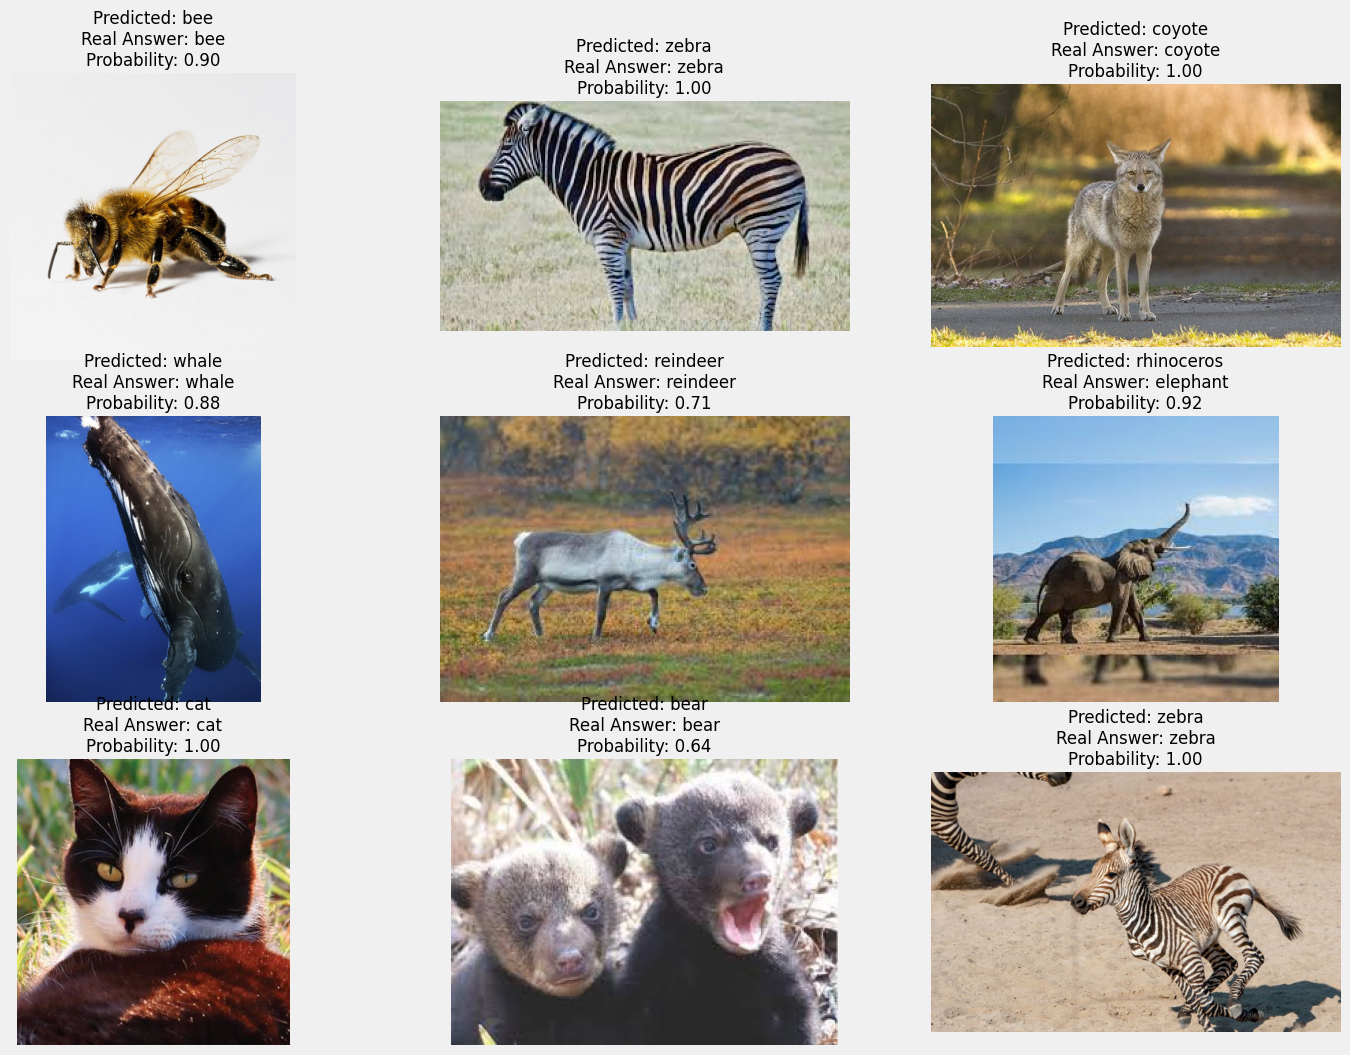

In [ ]:
#Show Test data
plt.figure(figsize=(16,12))
for i, row in Predictions.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(row['Path']))
    plt.title(f'Predicted: {row["Prediction Classes"]}\nReal Answer: {row["Test Classes"]}\nProbability: {row["Prediction Probability"]:.2f}', fontsize=12)
    plt.axis('off')
plt.show()


Show correct predictions

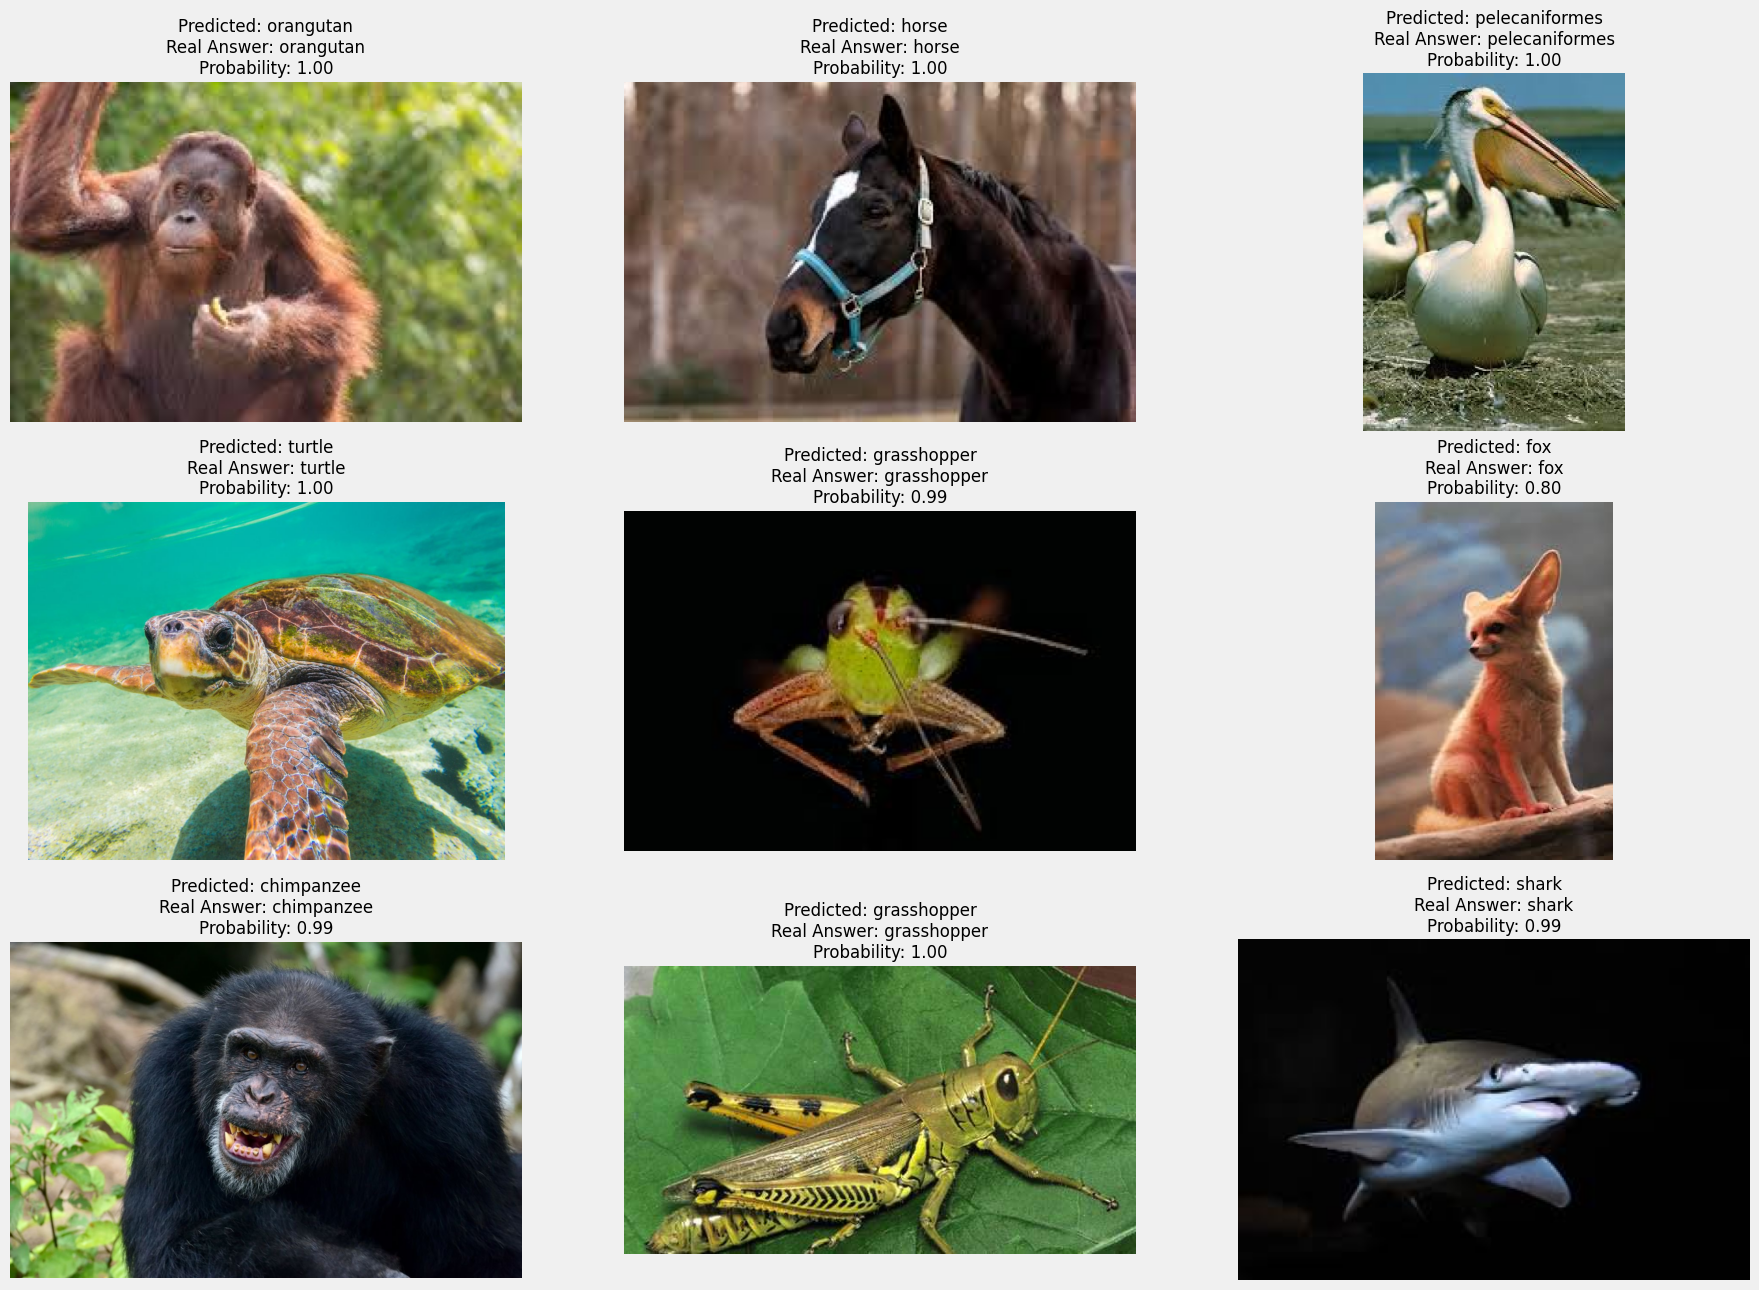

In [51]:
correct_predictions = Predictions[Predictions['Test Labels'] == Predictions['Prediction Labels']]
plt.figure(figsize=(20,15))
for i, row in correct_predictions.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(row['Path']))
    plt.title(f'Predicted: {row["Prediction Classes"]}\nReal Answer: {row["Test Classes"]}\nProbability: {row["Prediction Probability"]:.2f}', fontsize=12)
    plt.axis('off')
plt.show()


Show incorrect predictions

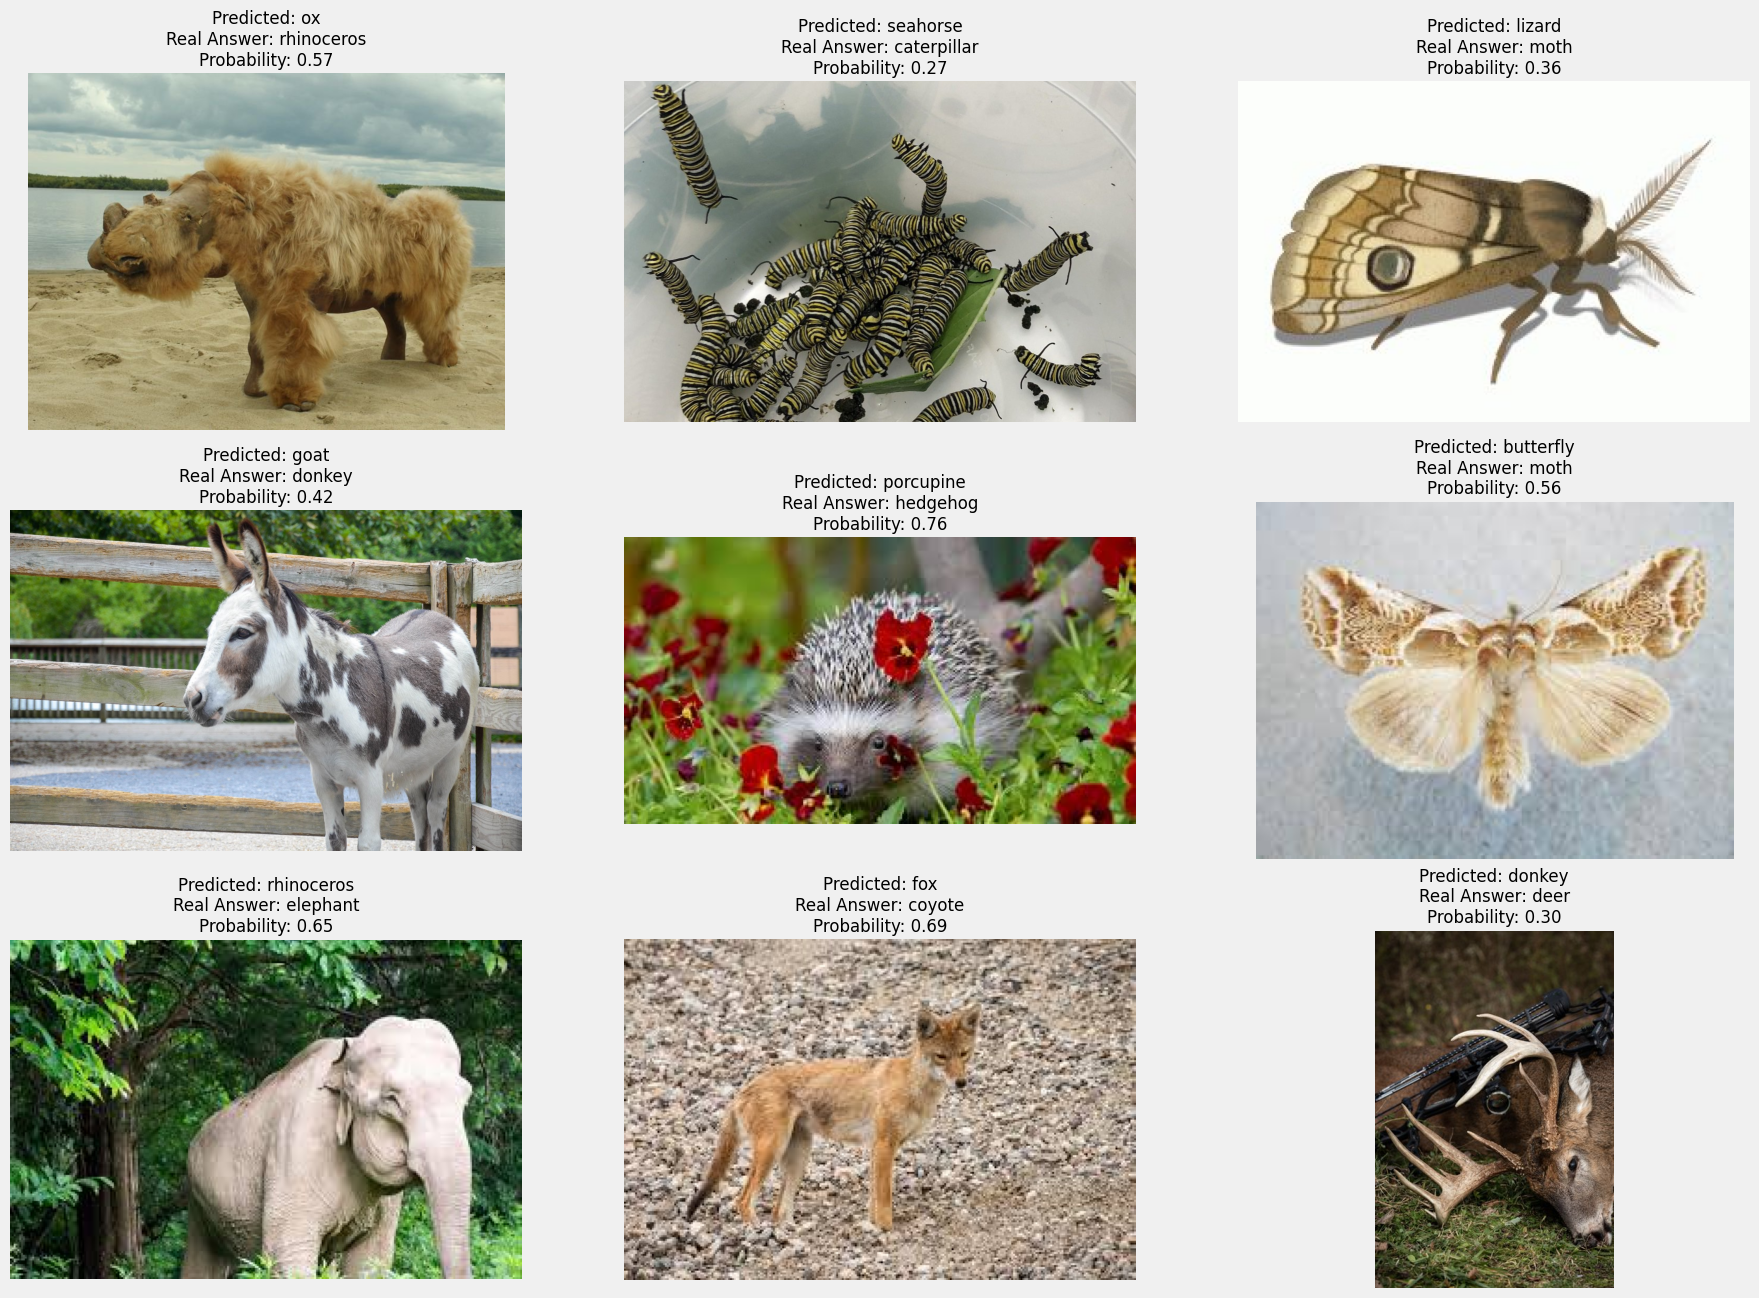

In [49]:
incorrect_predictions = Predictions[Predictions['Test Labels'] != Predictions['Prediction Labels']]
plt.figure(figsize=(20,15))
for i, row in incorrect_predictions.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(row['Path']))
    plt.title(f'Predicted: {row["Prediction Classes"]}\nReal Answer: {row["Test Classes"]}\nProbability: {row["Prediction Probability"]:.2f}', fontsize=12)
    plt.axis('off')
plt.show()